In [1]:
import os
import pickle
import numpy as np
from collections import OrderedDict

import matplotlib.pyplot as plt

from openmm import unit
from openmmtools.constants import kB
KT_KCALMOL = kB * 300 * unit.kelvin / unit.kilocalories_per_mole

In [17]:
class DataPlotter(object):
    
    def __init__(self, d_labels_to_info):
        """
        Parameters
        ----------
        d_labels_to_info : OrderedDict()
            contains free energy data for each experiment
            key : name of experiment (format: '{single letter amino acid of WT}{residue id}{single letter amino acid of mutant} 
                                                {phase} ({simulation type} r{replicate number})')
            value : dict with the following keys:
                key : list of file path(s) to free energy data
                key : list of starting indices to use in slicing the free energy data
                key : list of ending indices to use in slicing the free energy data
                key : total iterations to analyze 
            
            example: 
            d_labels_to_info = OrderedDict({
                "A42T complex (AREX r1)": {"file_paths": 
                                                   [os.path.join(base_path, sub_dir, "replicate_1", f"{phase}_free_energy_timeseries_1_50ns.pickle")],
                                               "slice_begs": [0],
                                               "slice_ends": [50],
                                               "total_iterations": 50000,
                                              }
                })
        """
        
        # Set unsampled state indices
        self.first_unsampled_state_index = 0
        self.last_unsampled_state_index = -1
        
        # Load complex free energy data
        data = OrderedDict()
        for i, (label, d_info) in enumerate(d_labels_to_info.items()):
            
            if "apo" not in label:
                
                # Load complex free energy matrices at each time point
                file_paths = d_info["file_paths"]
                slice_begs = d_info["slice_begs"]
                slice_ends = d_info["slice_ends"]
                total_iterations = d_info["total_iterations"]
                
                for j, (file_path, slice_beg, slice_end) in enumerate(zip(file_paths, slice_begs, slice_ends)):

                    if j == 0:
                        with open(file_path, "rb") as f:
                            results = pickle.load(f)
                        data[label] = {"results_complex": results[slice_beg:slice_end]}

                    else:
                        with open(file_path, "rb") as f:
                            results = pickle.load(f)
                        data[label]["results_complex"] += results[slice_beg:slice_end]

                data[label]["total_iterations"] = total_iterations
            
            else:
                
                # Load apo free energy data (10 ns/replica AREX)
                file_path_apo = d_info["file_paths"][0]
                with open(file_path_apo, "rb") as f:
                    results = pickle.load(f)
                data["results_apo"] = results
            
        # Experiment
        filepath_parts = file_path.split("/")
        sub_dir = int(filepath_parts[-3])
        experiment = [-0.1, 3.4, 1.6, 1.8, 0, 1.4, 0.5, 4.5, 7.7, 5.4, 5.2, 5.4, 5.5, 6.1, 0.1, -3.4, -1.6, -1.8, 0, -1.4, -0.5, -4.5, -7.7, -5.4, -5.2, -5.4, -5.5, -6.1]
        data["experiment"] = experiment[sub_dir]
        
        self.data = data
        
        # Set colors
        self.colors = ["#80b1d3", "#fdb462", "#b3de69"]
        
    def _generate_free_energy_timeseries_plot(self, 
                                              show_legend=False, 
                                              y_axis_min=None, 
                                              y_axis_max=None,
                                              y_axis_interval=None,
                                              legend_ncol=2,
                                              skip_replicate_label=False, 
                                              skip_replicate_linestyles=False,
                                              figsize=None,
                                              save_path=None):
        """
        Generate $\Delta G$ discrepancy (w.r.t experiment) timeseries plot 
        
        Parameters
        ----------
        show_legend : boolean, default False
            whether to show the legend
        y_axis_min : float, default None
            minimum value for the y axis
        y_axis_max : float, default None
            maximum value for the y axis
        y_axis_interval : float default None
            interval to place ticks between y_axis_min and y_axis_max
        legend_ncol : int, default 2
            number of columns in the legend
        skip_replicate_label : boolean, default False
            whether to skip inclusion of the replicate number in the label for the timeseries
        skip_replicate_linestyles : boolean, default False
            whether to skip using replicates to determine linestyles 
        figsize : tuple of ints, default None
            dimensions to use for generating the figure
        save_path : str
            filepath at which to save the figure
        """
        
        # Set default for y_axis_mean
        y_axis_mean = -1e6
    
        # Set figure size
        if not figsize:
            figsize = (8, 4)
        fig, axes = plt.subplots(nrows=1, ncols=1, sharex='col', figsize=figsize)
        
        # Assemble data
        dgs_all = {} # key : replicate, value: complex free energy timeseries
        ddgs_all = {} # key : replicate, value: complex uncertainty timeseries
        labels = [] # label for each simulation type
        for i, (label, data) in enumerate(self.data.items()):
            if label not in ["results_apo", "experiment"]: 
                
                # Get total ns
                total_ns = int(data["total_iterations"] / 1000)
                
                # Retrieve label
                title = label.split("(")[0][:-1]
                mutation = title.split(" ")[0]
                experiment_label = label.split("(")[-1][:-1]
                replicate = experiment_label[-1]
                simulation_type = experiment_label[:-3]
                if simulation_type not in labels:
                    labels.append(simulation_type)

                # Retrieve x values (time points)
                x = np.array(range(1000, data["total_iterations"] + 1, 1000)) / 1000

                # Retrieve complex free energies in kcal/mol
                dgs = np.array([t["Deltaf"][self.first_unsampled_state_index, self.last_unsampled_state_index] * KT_KCALMOL for t in data["results_complex"]])
                ddgs = np.array([t["dDeltaf"][self.first_unsampled_state_index, self.last_unsampled_state_index] * KT_KCALMOL for t in data["results_complex"]])

                # Store the complex free energy timeseries 
                if replicate not in dgs_all:
                    dgs_all[replicate] = {simulation_type: dgs}
                    ddgs_all[replicate] = {simulation_type: ddgs}
                else:
                    dgs_all[replicate][simulation_type] = dgs
                    ddgs_all[replicate][simulation_type] = ddgs

        # Assemble apo free energies
        apo_dg = self.data["results_apo"]["Deltaf"][self.first_unsampled_state_index, self.last_unsampled_state_index] * KT_KCALMOL
        apo_ddg = self.data["results_apo"]["dDeltaf"][self.first_unsampled_state_index, self.last_unsampled_state_index] * KT_KCALMOL

        # Set font size
        plt.rc('font', size=20) 
        
        # Plot
        linestyles = ["solid", "dotted", "dashed"]
        for replicate in dgs_all:
            for label, dgs in dgs_all[replicate].items():

                complex_dgs = dgs
                complex_ddgs = ddgs_all[replicate][label]
                experiment = self.data["experiment"]
                y = (complex_dgs - apo_dg) - experiment
                yerr = ((apo_ddg**2 + complex_ddgs**2 + 0.1**2)**0.5)
                print(y)
                print(yerr)

                label_final = f"{label}" if skip_replicate_label else f"{label} r{replicate}"
                linestyle = "solid" if skip_replicate_linestyles else linestyles[int(replicate)]
                axes.plot(x, y, label=label_final, color=self.colors[labels.index(label)], linestyle=linestyle)
                axes.fill_between(x, y - (2 * yerr), y + (2 * yerr), color=self.colors[labels.index(label)], alpha=0.5)

                # Determine y axis mean
                y_mean = np.mean(y)
                if y_mean > y_axis_mean:
                    y_axis_mean = y_mean
            
        # Plot zero bias
        axes.axhline(y=0, linestyle='dotted', linewidth=2, color='gray')
        
        # Handle legend
        if show_legend:
            axes.legend(ncol=legend_ncol)
        
        # Set x and y axis labels
        y_label = r"$\Delta\Delta G$ discrepancy" + "\n(kcal/mol)"
        axes.set_ylabel(y_label)
        axes.set_xlabel("Complex phase simulation time (ns)")
        
        # Set x and y limits
        if not y_axis_min:
            y_axis_min = round(y_axis_mean) - 4
        if not y_axis_max:
            y_axis_max = round(y_axis_mean) + 8
        if not y_axis_interval:
            y_axis_interval = 2.0
        plt.yticks(np.arange(y_axis_min, y_axis_max, y_axis_interval))
        if total_ns == 10:
            plt.xticks(np.arange(1, total_ns + 1, 1.0))
        else:
            plt.xticks([1] +  list(np.arange(10, total_ns + 1, 10.0)))
        
        # Set title
        axes.set_title(mutation)
        
        # Ensure x-axis labels are not cut off
        plt.tight_layout()

        # Save plot as pdf
        if save_path:
            plt.savefig(save_path, dpi=500)
            plt.show()
            plt.clf()
        else:
            plt.show()
        


# Barnase:barstar

## AREX vs AREST (0.5 nm 600 K)

### Complex 50 ns

[5.50886205 4.88614874 4.31300745 3.79566858 3.39798986 3.09809524
 2.89913569 2.74966986 2.68621514 2.54569212 2.42508145 2.31827513
 2.20589176 2.13945673 2.09792964 2.01156477 1.94832337 1.897061
 1.80852088 1.76590597 1.64074687 1.54416805 1.49813377 1.46307296
 1.44446657 1.43485699 1.4466779  1.45843398 1.47185793 1.48448424
 1.50493801 1.50674281 1.49353881 1.48491024 1.46693637 1.47757823
 1.46686541 1.44420974 1.43316329 1.40158044 1.37629011 1.36039066
 1.34464752 1.31322505 1.30680086 1.31134774 1.28213748 1.25045297
 1.23173788 1.2178736 ]
[0.33349175 0.27623918 0.235844   0.22732474 0.21116517 0.20251243
 0.19160413 0.18440517 0.18984859 0.18571693 0.18520622 0.17829975
 0.18179497 0.1800824  0.1806482  0.17823378 0.17313932 0.17372157
 0.177677   0.17471131 0.16985805 0.17118307 0.17183818 0.17198315
 0.17231813 0.17100459 0.17149685 0.173029   0.17320971 0.17119487
 0.17161813 0.17047381 0.16853391 0.17094306 0.17087661 0.16953394
 0.16748647 0.16830104 0.1708883  0.1674

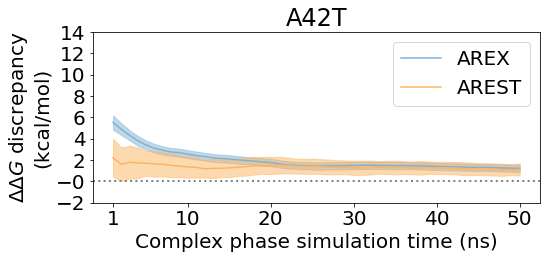

<Figure size 432x288 with 0 Axes>

In [10]:
# A42T
main_dir = 45
main_dir_rest = 52
phase = 'complex'
base_path = f"/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/{main_dir}/"
base_path_rest = f"/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/{main_dir_rest}/"

sub_dir = "9"
sub_dir_rest = "17"
d_labels_to_info = OrderedDict({
                    "A42T apo (AREX r0)": {"file_paths": 
                                                   [os.path.join(base_path, sub_dir, "replicate_1", f"apo_free_energy_bootstrapped_10ns.pickle")],
                                              },
                    "A42T complex (AREX r1)": {"file_paths": 
                                                   [os.path.join(base_path, sub_dir, "replicate_1", f"{phase}_free_energy_timeseries_1_50ns.pickle")],
                                               "slice_begs": [0],
                                               "slice_ends": [50],
                                               "total_iterations": 50000,
                                              },
                    "A42T complex (AREST r0)": {"file_paths": 
                                                    [os.path.join(base_path_rest, sub_dir_rest, "replicate_0", f"{phase}_free_energy_timeseries_1_50ns.pickle")],
                                                "slice_begs": [0],
                                                "slice_ends": [50],
                                                "total_iterations": 50000,
                                              },
                    })

save_path = os.path.join(base_path_rest, sub_dir_rest, "replicate_0", f"{sub_dir_rest}_{phase}_series_50ns.pdf")
data_plotter = DataPlotter(d_labels_to_info)
data_plotter._generate_free_energy_timeseries_plot(show_legend=True, y_axis_min=-2.01, y_axis_max=14, legend_ncol=1, skip_replicate_label=True, skip_replicate_linestyles=True, save_path=save_path)



[10.48480664  9.49553046  8.70463342  7.98764652  7.67834646  7.25016312
  6.91648832  6.36340248  5.92826227  5.5219656   5.27665882  5.13529403
  4.92417282  4.719976    4.57058448  4.38405739  4.20185005  4.02409176
  3.83286567  3.69401595  3.56913253  3.40987448  3.24682605  3.13199883
  3.01972678  2.88457503  2.76943175  2.71134372  2.6296148   2.55239704
  2.45545413  2.3650245   2.2743494   2.17657206  2.09061764  2.00781469
  1.9381507   1.91452994  1.83696464  1.7610836   1.68170334  1.62120041
  1.57257005  1.51267122  1.47100313  1.43667768  1.40475192  1.38818408
  1.35027258  1.30682848]
[1.20442871 1.01267459 0.90831394 0.81236569 0.79194894 0.75303107
 0.7042178  0.70544306 0.68245327 0.69713135 0.66514691 0.65747126
 0.64091097 0.6332264  0.62459789 0.63176006 0.62570401 0.61835712
 0.60250208 0.5963717  0.60262736 0.60386371 0.60174269 0.6004962
 0.59053807 0.58691325 0.59201158 0.59362057 0.59682342 0.58553045
 0.58633246 0.59011854 0.57947648 0.57633167 0.57945855 

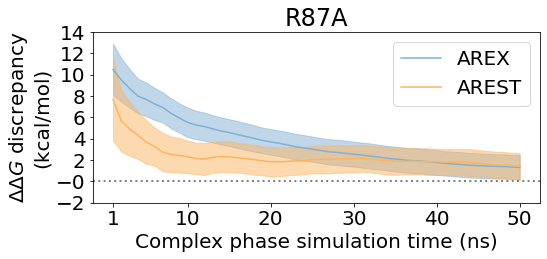

<Figure size 432x288 with 0 Axes>

In [11]:
main_dir = 45
main_dir_rest = 52
phase = 'complex'
base_path = f"/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/{main_dir}/"
base_path_rest = f"/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/{main_dir_rest}/"

sub_dir = "10"
sub_dir_rest = "12"
d_labels_to_info = OrderedDict({
                    "R87A apo (AREX r0)": {"file_paths": 
                                                   [os.path.join(base_path, sub_dir, "replicate_1", f"apo_free_energy_bootstrapped_10ns.pickle")],
                                              },
                    "R87A complex (AREX r1)": {"file_paths": 
                                                   [os.path.join(base_path, sub_dir, "replicate_1", f"{phase}_free_energy_timeseries_1_50ns.pickle")],
                                               "slice_begs": [0],
                                               "slice_ends": [50],
                                               "total_iterations": 50000,
                                              },
                    "R87A complex (AREST r0)": {"file_paths": 
                                                    [os.path.join(base_path_rest, sub_dir_rest, "replicate_0", f"{phase}_free_energy_timeseries_1_50ns.pickle")],
                                                "slice_begs": [0],
                                                "slice_ends": [50],
                                                "total_iterations": 50000,
                                              },
                    })

save_path = os.path.join(base_path_rest, sub_dir_rest, "replicate_0", f"{sub_dir_rest}_{phase}_series_50ns.pdf")
data_plotter = DataPlotter(d_labels_to_info)
data_plotter._generate_free_energy_timeseries_plot(show_legend=True, y_axis_min=-2.01, y_axis_max=14, legend_ncol=1, skip_replicate_label=True, skip_replicate_linestyles=True, save_path=save_path)



[6.31493799 4.11713381 3.45159614 2.9727469  2.69829696 2.63681384
 2.52935656 2.38041023 2.27249945 2.1819579  2.25075362 2.36015458
 2.47497293 2.56614975 2.58528215 2.62627129 2.73702908 2.79072986
 2.81965284 2.82131095 2.86386233 2.92117459 2.97036016 2.99430828
 3.01957183 3.04924622 3.08624167 3.11471215 3.13079609 3.08849218
 3.04951111 3.05180436 3.052725   3.07701052 3.07202893 3.05432961
 3.02328875 3.0100634  2.98174806 2.98062422 2.97363327 2.96466824
 2.97060933 2.96483908 2.94626274 2.92025515 2.89532315 2.85363676
 2.81273962 2.78504836]
[1.14532603 0.99424563 0.89282494 0.7732033  0.76319263 0.72462118
 0.68983428 0.70151762 0.68277914 0.67061627 0.67899654 0.66237146
 0.65314287 0.64782596 0.65373922 0.64400289 0.65324819 0.64539725
 0.64041424 0.63935045 0.6391554  0.64385742 0.62981926 0.63867944
 0.62666171 0.62848222 0.62892116 0.62508292 0.61748247 0.63736773
 0.62556311 0.62524935 0.61789148 0.62663923 0.60812874 0.62024897
 0.62541331 0.62303084 0.61696593 0.61

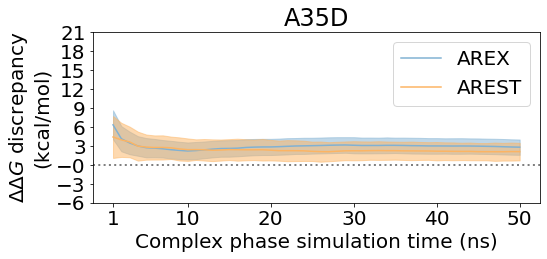

[ 6.93616472  3.93518668  2.62098833  1.61805918  1.04690399  0.68128031
  0.42739849  0.25381227  0.22701939  0.07321787 -0.03453393 -0.14780564
 -0.19009138 -0.28838445 -0.38594585 -0.4412137  -0.47185903 -0.52995348
 -0.54050435 -0.58347695 -0.60983356 -0.64125133 -0.67956309 -0.7091716
 -0.72575078 -0.75484369 -0.79902251 -0.84529096 -0.89730625 -0.96625523
 -1.05310904 -1.08127465 -1.08461934 -1.12946509 -1.16219126 -1.19225918
 -1.18543676 -1.15413603 -1.16605772 -1.17736978 -1.19868631 -1.20156919
 -1.20834061 -1.2093934  -1.19924703 -1.20775211 -1.2090278  -1.2323327
 -1.22028036 -1.21222686]
[1.22720766 1.07203168 0.92409155 0.87935876 0.80581751 0.74510969
 0.73050042 0.68629337 0.68293622 0.64049868 0.65396972 0.65515423
 0.61734743 0.60060074 0.61428433 0.60930394 0.60066725 0.59290864
 0.59238323 0.58770235 0.60560413 0.55263888 0.57905814 0.56884647
 0.5725759  0.56696551 0.55689877 0.56002552 0.5522292  0.56010272
 0.54872457 0.55839721 0.54687879 0.55105752 0.55486143 0

<Figure size 432x288 with 0 Axes>

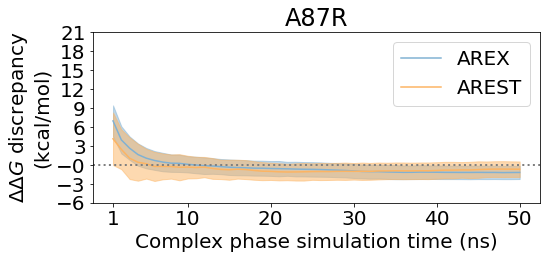

[3.90100471 3.77798236 3.54713188 3.44189946 3.33406488 3.25700866
 3.18448907 3.06223062 2.94213692 2.73247545 2.60156621 2.5225992
 2.4364871  2.33088103 2.26069888 2.23448831 2.20688838 2.13515025
 2.06187379 2.01224204 1.97123444 1.92469121 1.889721   1.86016235
 1.81327621 1.76748306 1.72901304 1.7064709  1.65882639 1.61543014
 1.56224288 1.51767135 1.47344183 1.45987665 1.4290658  1.38567585
 1.34634954 1.32050513 1.31070008 1.28537528 1.24711206 1.22963567
 1.21377644 1.20293923 1.18386496 1.15485682 1.12427861 1.09244137
 1.05933158 1.02969088]
[0.34483939 0.2983624  0.28622601 0.25552921 0.24840572 0.2452003
 0.22700423 0.23387443 0.22401846 0.21533424 0.21557295 0.21292815
 0.20678123 0.21060909 0.20559555 0.20727599 0.20812931 0.20627644
 0.20102937 0.20253408 0.20122268 0.19523463 0.19889925 0.19662203
 0.19864686 0.19760806 0.19512347 0.19795648 0.19549992 0.19532475
 0.19560246 0.19412107 0.19496811 0.19393965 0.19688896 0.19182577
 0.19309922 0.1954316  0.1935738  0.1942

<Figure size 432x288 with 0 Axes>

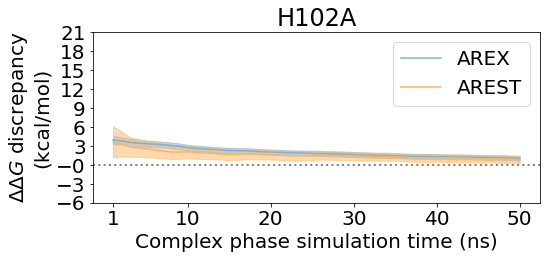

[6.23026615 4.20296059 3.63286209 2.74042345 2.23971538 1.82761739
 1.25579303 1.03258894 0.9430936  0.79087023 0.70646257 0.66069056
 0.66200503 0.66036816 0.62136101 0.5575372  0.58175938 0.61178927
 0.62757452 0.59625763 0.56412923 0.55423243 0.56938301 0.62544481
 0.65505019 0.67941475 0.6741347  0.6967442  0.7140935  0.74361259
 0.74710644 0.74077066 0.76151592 0.77506468 0.76268344 0.77513749
 0.80744868 0.8424898  0.88495052 0.91307895 0.92273658 0.95228835
 0.99394035 1.02098429 1.03509113 1.07206958 1.08470634 1.09212091
 1.10905954 1.11622119]
[1.20520486 0.98677206 0.88447298 0.82087709 0.79536363 0.76445489
 0.74373831 0.74204304 0.70740794 0.71527735 0.72742876 0.710091
 0.69093022 0.65029878 0.64872215 0.66486194 0.65108828 0.63142552
 0.64213104 0.64290659 0.6394805  0.62290625 0.61763239 0.63005286
 0.61726765 0.61674729 0.62836926 0.61207617 0.60464784 0.60595932
 0.61355033 0.62123003 0.60564216 0.60706945 0.60172532 0.60395755
 0.59791854 0.59638664 0.60217017 0.6004

<Figure size 432x288 with 0 Axes>

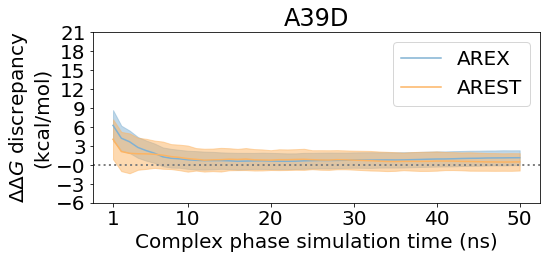

[ 2.5570755   1.28074921  0.47586163  0.30712711  0.19434166 -0.07148662
 -0.31081962 -0.37109108 -0.59615413 -0.7478086  -0.94721827 -1.01648067
 -1.11162395 -1.24714883 -1.41179675 -1.45402275 -1.47608632 -1.54178961
 -1.53987007 -1.57651186 -1.57792546 -1.65537273 -1.71222564 -1.76301774
 -1.79834401 -1.81844181 -1.80587526 -1.82380616 -1.85290463 -1.88179121
 -1.87343386 -1.8703881  -1.86449065 -1.82478995 -1.808335   -1.79118251
 -1.8345887  -1.87037043 -1.89816694 -1.92619678 -1.93709252 -1.95390425
 -1.96446993 -1.94457872 -1.9364616  -1.94216369 -1.97032773 -2.00339832
 -2.03527191 -2.04916011]
[1.30779106 0.95074309 0.86054842 0.75523678 0.74726526 0.65265242
 0.64394465 0.58606602 0.59268164 0.55557326 0.54556298 0.51379163
 0.5325702  0.52495909 0.53600933 0.52518368 0.52906897 0.52030063
 0.51652868 0.51575359 0.48924931 0.49146339 0.50168298 0.48864298
 0.48362044 0.51270797 0.48984049 0.47436541 0.48007305 0.48376806
 0.49446689 0.48194235 0.47659778 0.4773856  0.47389363

<Figure size 432x288 with 0 Axes>

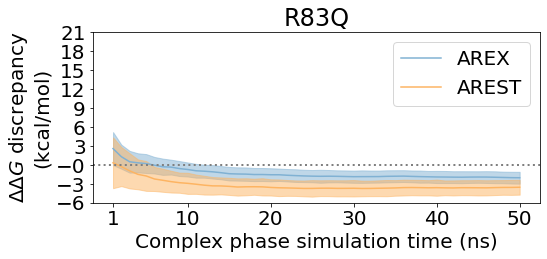

[17.93966551 14.75110607 13.38597563 12.31968373 11.22662983 10.59299649
  9.97584452  9.38303408  8.93787549  8.6463235   8.3873555   8.09783291
  7.80298801  7.71586374  7.55794077  7.4249103   7.34964831  7.24258364
  7.11565067  7.01895911  6.94638173  6.8735627   6.84314946  6.80592898
  6.78890727  6.71381874  6.58828956  6.48790024  6.43460702  6.35396861
  6.24975114  6.20184395  6.11997017  6.0386607   5.95557224  5.89253035
  5.77378799  5.68934622  5.61005476  5.54052742  5.48538391  5.43257664
  5.39215308  5.33968272  5.26313253  5.20004091  5.14155418  5.1092756
  5.0760254   5.0221058 ]
[1.4075851  1.08449116 1.03770715 0.91075091 0.83220768 0.81052548
 0.78027726 0.79422731 0.71646291 0.71521606 0.69512677 0.71333989
 0.67974173 0.66621296 0.6638106  0.65085654 0.64444026 0.65521994
 0.6464439  0.63817823 0.636202   0.63260657 0.64447944 0.62538674
 0.62498089 0.61792649 0.62122158 0.62230268 0.61822019 0.61307622
 0.61891742 0.61940125 0.61796517 0.61869218 0.61970163 

<Figure size 432x288 with 0 Axes>

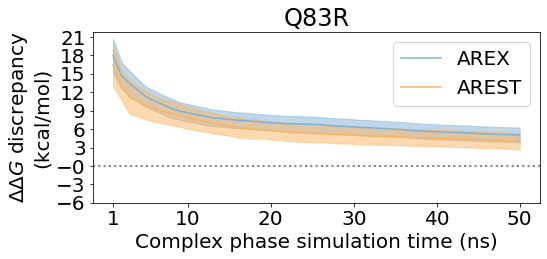

<Figure size 432x288 with 0 Axes>

In [18]:
main_dir_rest = 52
phase = 'complex'

d_mutations = {
               "A35D": {"main_dir": 47, 
                      "sub_dir": "21",
                      "rest_replicate": 1},
    
               "A87R": {"main_dir": 47, 
                      "sub_dir": "26"},
        
               "H102A": {"main_dir": 47,
                        "sub_dir": "13"},
               
               "A39D": {"main_dir": 47,
                         "sub_dir": "22"
                        },
    
               "R83Q": {"main_dir": 47,
                     "sub_dir": "11"
                    },
               
               "Q83R": {"main_dir": 47,
                         "sub_dir": "25"
                        }
            }

for name, info in d_mutations.items():
    
    main_dir = info["main_dir"]
    sub_dir = info["sub_dir"]
    sub_dir_rest = info["sub_dir"]
    rest_replicate = info["rest_replicate"] if "rest_replicate" in info else 0
    
    base_path = f"/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/{main_dir}/"
    base_path_rest = f"/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/{main_dir_rest}/"

    d_labels_to_info = OrderedDict({
                        f"{name} apo (AREX r1)": {"file_paths": 
                                                       [os.path.join(base_path, sub_dir, f"replicate_1", f"apo_free_energy_bootstrapped_10ns.pickle")],
                                                  },
                        
                        f"{name} complex (AREX r1)": {"file_paths": 
                                                       [os.path.join(base_path, sub_dir, "replicate_1", f"{phase}_free_energy_timeseries_1_50ns.pickle")],
                                                   "slice_begs": [0],
                                                   "slice_ends": [50],
                                                   "total_iterations": 50000,
                                                  },

                        f"{name} complex (AREST r{rest_replicate})": {"file_paths": 
                                                        [os.path.join(base_path_rest, sub_dir_rest, f"replicate_{rest_replicate}", f"{phase}_free_energy_timeseries_1_50ns.pickle")],
                                                    "slice_begs": [0],
                                                    "slice_ends": [50],
                                                    "total_iterations": 50000,
                                                  },
                        })

    save_path = os.path.join(base_path_rest, sub_dir_rest, "replicate_0", f"{sub_dir_rest}_{phase}_series_50ns.pdf")
    data_plotter = DataPlotter(d_labels_to_info)
#     y_axis_min = -6.01 if name == "R83Q" else -2.01
#     y_axis_max = 22 if name == "Q83R" else 14
    y_axis_min = -6.01
    y_axis_max = 22
    y_axis_interval = 3
    data_plotter._generate_free_energy_timeseries_plot(show_legend=True, y_axis_min=y_axis_min, y_axis_max=y_axis_max, y_axis_interval=y_axis_interval, legend_ncol=1, skip_replicate_label=True, skip_replicate_linestyles=True, save_path=save_path)

